In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [4]:
style.use('fivethirtyeight')

In [5]:
songs = pd.read_csv('./data/ten_genres_500_samp.csv')

In [6]:
X = songs._get_numeric_data().drop(columns=['key', 'mode'])
y = songs['genre']

In [7]:
def running_models(X, y, scaled=False, c=.65):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)
    
    # MODELING WITH SCALED FEATURES #
    
    # Scale the features
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    # Creating a df to display results
    model_df = pd.DataFrame(columns=['train_score', 'test_score'])
    
    model_sc = SVC(C=c, kernel='rbf', degree=3)
    model_sc.fit(X_train_sc, y_train)
    train_score = model_sc.score(X_train_sc, y_train)
    test_score = model_sc.score(X_test_sc, y_test)
    
    row = {'model': type(model_sc).__name__,
           'train_score' : train_score,
          'test_score' : test_score,
           'C': c,
          'scaled': True}
    model_df = model_df.append(row, ignore_index=True)
    
    # MODELING WITH UNSCALED FEATURES #
    
    model = SVC(C=20000, kernel='rbf', degree=3)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    row = {'model': type(model).__name__,
       'train_score' : train_score,
      'test_score' : test_score,
       'C': 20000,
      'scaled': False}
    model_df = model_df.append(row, ignore_index=True)
    return model_df

In [8]:
running_models(X, y)

,train_score,test_score,C,model,scaled
0,0.553867,0.5056,0.65,SVC,1.0
1,0.542933,0.4952,20000.00,SVC,0.0


For the 10-genre dataset, **Spotify's best accuracy is $\approx$ 50.6%**, this will be the baseline to compare my models against.

## Visualizing the results
Let's dig in and see what we can glean from the results of the predictions using Spotify's features

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [10]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [11]:
# .5056
model = SVC(C=.65, kernel='rbf')
cross_val_score(model, X_train_sc, y_train, n_jobs=12)

array([0.50266667, 0.51733333, 0.50533333, 0.49733333, 0.512     ])

The model has a decent cross validation score, **there don't seem to be any drastic blind spots**, as all the scores are within a 2% range.

In [12]:
model.fit(X_train_sc, y_train)

SVC(C=0.65)

In [13]:
y_preds = model.predict(X_test_sc)

In [14]:
results = X_test.copy()

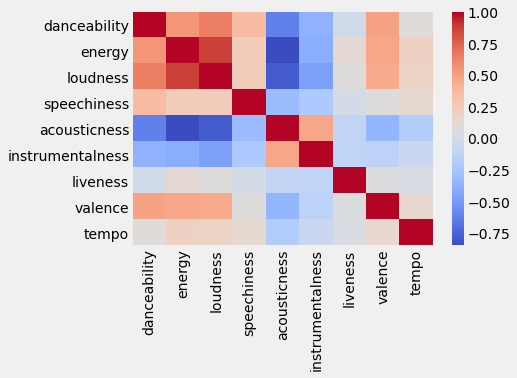

In [15]:
sns.heatmap(results.corr(), cmap='coolwarm');

There's a high **positive correlation between loudness and energy** and a high **negative correlation between energy and acousticness**

In [16]:
results.loc[:, 'genre'] = y_test.copy()

In [17]:
results.loc[:, 'preds'] = y_preds.copy()

In [18]:
results_wrong = results[results['genre'] != results['preds']]

In [19]:
results_wrong['genre'].value_counts(normalize=True)

pop                      0.173139
classical                0.155340
hip hop                  0.142395
r&b                      0.131068
rap                      0.113269
baroque                  0.077670
rock                     0.066343
tropical house           0.048544
serialism                0.046926
progressive bluegrass    0.045307
Name: genre, dtype: float64

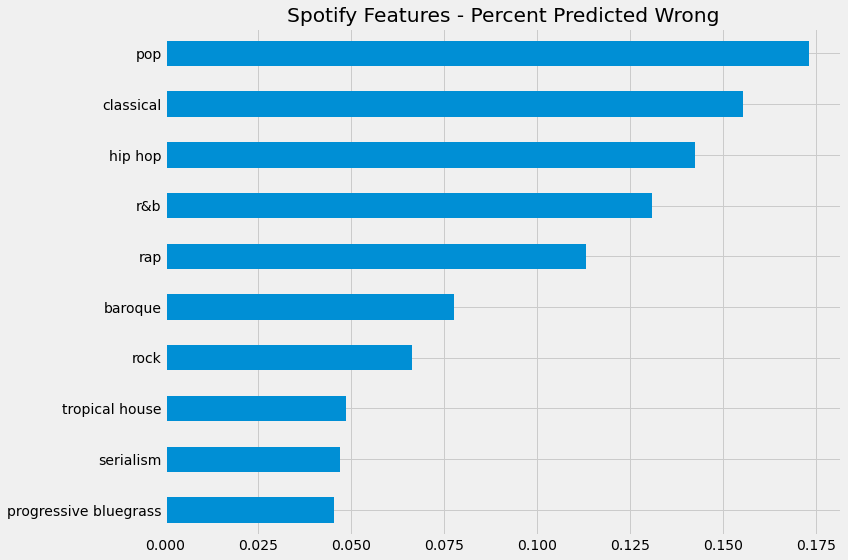

In [112]:
results_wrong['genre'].value_counts(normalize=True).sort_values().plot(kind='barh', title='Spotify Features - Percent Predicted Wrong', figsize=(12, 8))
plt.tight_layout()
plt.savefig('./images/wrongpreds_10g_spotify.png', dpi=72);

Pop and classical seem to be predicted wrong most often based on the features Spotify has pulled from the music.

In [21]:
results_wrong[results_wrong['genre'] == 'rap']['preds'].value_counts(normalize=True)

hip hop                  0.414286
r&b                      0.185714
tropical house           0.185714
pop                      0.142857
rock                     0.057143
progressive bluegrass    0.014286
Name: preds, dtype: float64

It seems that when Rap is predicted wrong, it's predicted as R&B about 89.1% of the time

In [22]:
results_wrong[results_wrong['genre'] == 'r&b']['preds'].value_counts(normalize=True)

hip hop                  0.246914
pop                      0.234568
rap                      0.234568
rock                     0.135802
tropical house           0.086420
progressive bluegrass    0.049383
baroque                  0.012346
Name: preds, dtype: float64

R&B is most likely to be predicted as rap, but only 47.3% of the time.

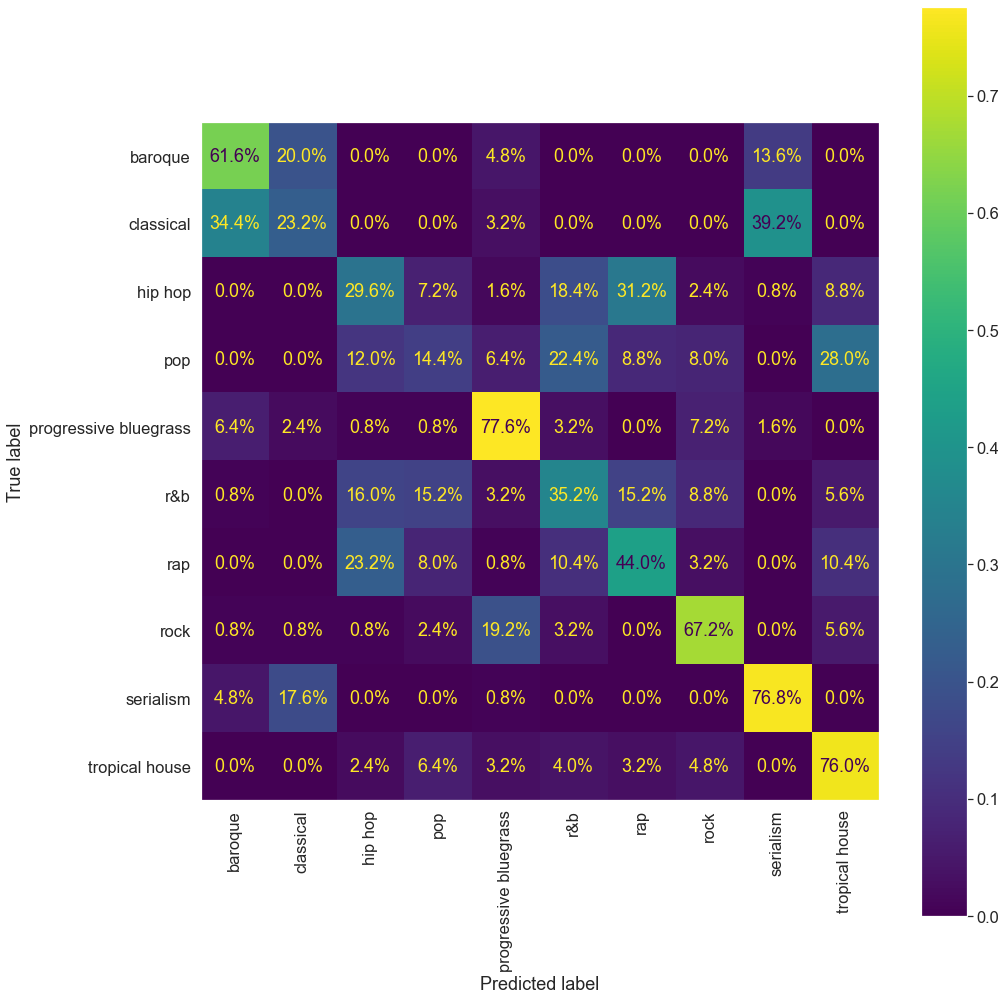

In [117]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=1.5)
plot_confusion_matrix(model, X_test_sc, y_test, 
                      xticks_rotation='90', 
                      values_format='.1%', 
                      normalize='true', ax=ax)
plt.grid(False)
plt.tight_layout()
plt.savefig('./images/extracted_10g_confmatrix.png', dpi=72);

In [78]:
genre_mean = songs.groupby('genre').mean()

In [80]:
genre_median = songs.groupby('genre').median()

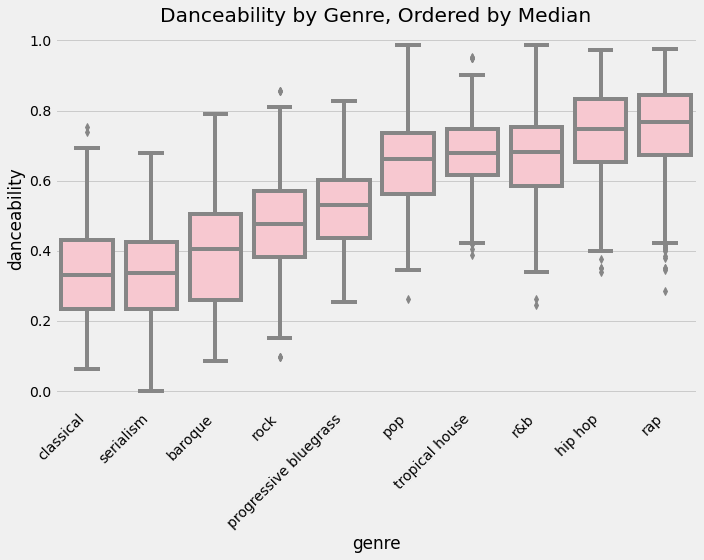

In [110]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=songs, y='danceability', x='genre', 
            color='pink', 
            order=genre_median['danceability'].sort_values().index)
plt.title('Danceability by Genre, Ordered by Median')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./images/danceability_10g.png', dpi=72);


It looks like Rap has the highest median danceability at over 0.7, classical has the lowest median danceability at just above 0.3.

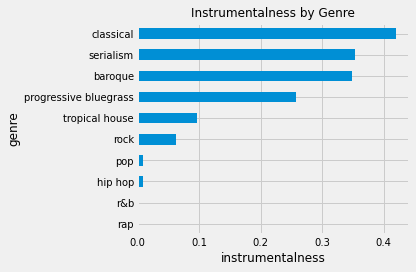

In [107]:
genre_mean['instrumentalness'].sort_values().plot(kind='barh', fontsize=10)
plt.title('Instrumentalness by Genre', size=12)
plt.xlabel('instrumentalness', size=12)
plt.ylabel('genre', size=12)
plt.tight_layout()
plt.savefig('./images/instrumentalness_by_genre.png', dpi=100);

Classical has the highest instrumentalness, while rap has the lowest

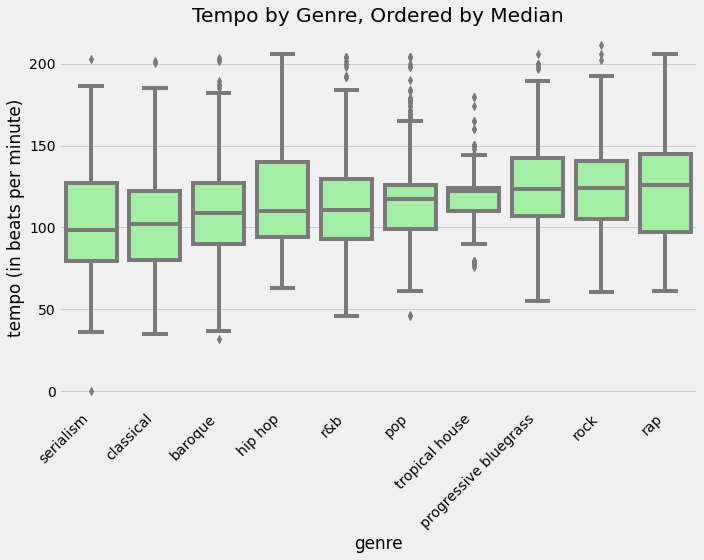

In [111]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=songs, y='tempo', x='genre', 
            color='palegreen', 
            order=genre_median['tempo'].sort_values().index,)
plt.title('Tempo by Genre, Ordered by Median')
plt.xticks(rotation=45, ha='right')
plt.ylabel('tempo (in beats per minute)')
plt.tight_layout()
plt.savefig('./images/tempo_by_genre.png', dpi=72);

Interesting that most of the genres hover around 120 beats per minute, with baroque, classical, and serialism being on the slower side*

*Note that the tempo here is derived from the music itself, and may not be completely accurate - especially in music that doesn't have a strong or consistent pulse, this can be difficult to predict.

## What's next?

Now that I've seen how accurate models can be with the features that Spotify provides, I want to create/extract my own features from the audio I've pulled from Spotify.